## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import keras
import itertools
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(x_train, y_train),(x_test, y_test ) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    model = Sequential()
    model.add(Dense(units = input_shape[1] ,input_dim = input_shape[1], kernel_initializer = 'normal', activation = 'relu',name = 'input'))
    
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units, kernel_initializer='normal', activation='relu',name="hidden_layer"+str(i+1)))  
        model.add(BatchNormalization())         
    
    model.add(Dense(units=output_units,kernel_initializer='normal', activation='softmax',name='output'))

    return model

In [0]:
def plot_model_score(results):
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label='valid-'+cond, color=color_bar[i])
   
    plt.title("Loss")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label='valid-'+cond, color=color_bar[i])
   
    plt.title("Accuracy")
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [0]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCES=[5,15,25]
FACTORS=[0.2,0.5,0.8]

In [11]:
results = {}

for factor,patience in itertools.product(FACTORS,PATIENCES):
    keras.backend.clear_session() 
    # 載入 Callbacks
    reduce_lr = ReduceLROnPlateau(factor=factor,min_lr=1e-12, monitor='val_loss', patience=patience, verbose=1)
    
    model = build_mlp(input_shape=x_train.shape)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reduce_lr]
                  )
   
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'Factor={factor},patience={patience}'
    
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             }
    
   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

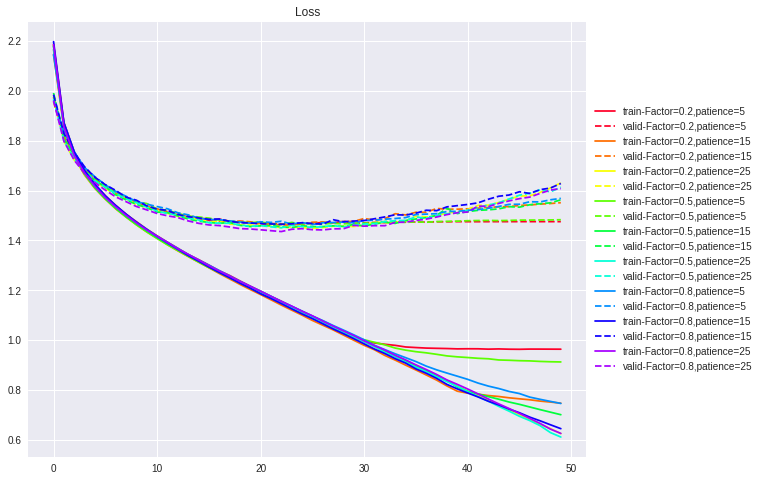

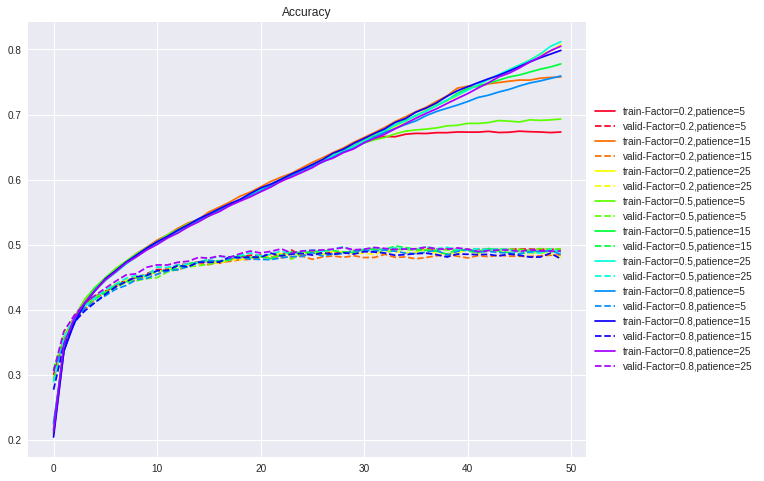

In [14]:
# 繪製結果
plot_model_score(results)

## 將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果


In [0]:
Sgd = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
RMSprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

optimizers = ['Sgd','Adam','RMSprop']

In [17]:
results = {}

for  optimizer in optimizers:
    keras.backend.clear_session() 
    # 載入 Callbacks
    reduce_lr = ReduceLROnPlateau(factor=0.5,min_lr=1e-12, monitor='val_loss', patience=5, verbose=1)
    
    model = build_mlp(input_shape=x_train.shape)
    model.summary()
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reduce_lr]
                  )
   
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'Optimizer={optimizer}'
    
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             }
    
   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

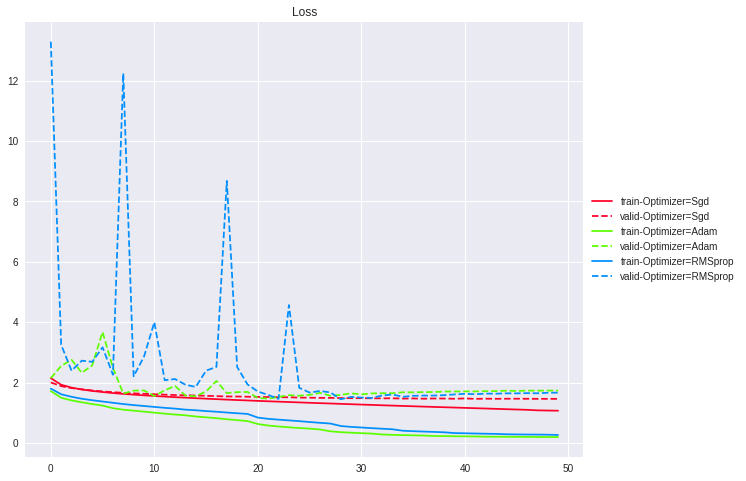

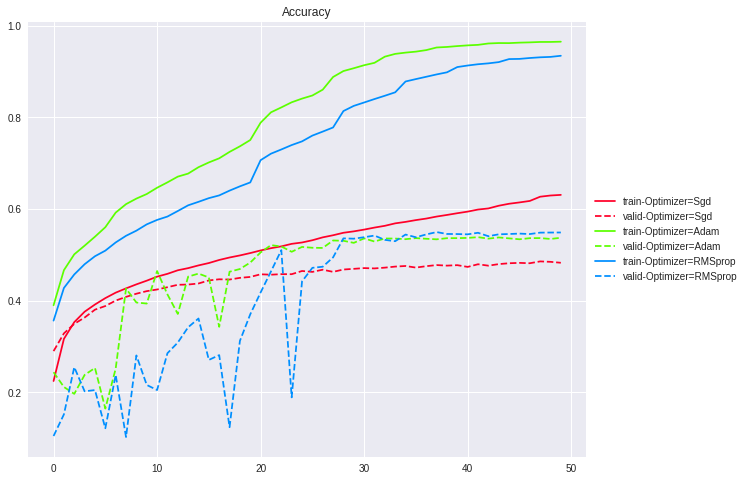

In [18]:
plot_model_score(results)